# Theory: Neural Networks are Universal Function Approximators
It is a well-known result that neural networks can approximate any continuous function $ \mathbb{R}^n \to \mathbb{R}^m $. Even neural networks with a single hidden layer have this property. By adding more neurons to this layer, you should be able to approximate the function with increasing accuracy. However, being able to approximate a function in theory is different from being able to actually find parameters which generate a good fit in practice. In this notebook, we will explore this difficulty (of finding good parameters), and investigate the relationship between the complexity of a model and how well it approximates a given function.

### Our function of choice: The Weierstrass function
The Weierstrass function is defined by:

$$ \sum_{n=0}^\infty \alpha^n \cos(\beta^n\pi x) $$

Where $ 0 < \alpha < 1 $ The Weierstrass function has the interesting property that it is continuous everywhere and yet differentiable nowhere. This is true in the limiting case where the number of terms in the series becomes arbitrarily large. For our purposes, we are going to cap the number of terms at some set N:

$$ W_N(x) = \sum_{n=0}^N \alpha^n \cos(\beta^n\pi x) $$

What is useful about the above function is that we can use our variable N to dial up and down how chaotic the function behaves. In the limiting case, where $ N \to \infty $, the function is differentiable nowhere. In some sense, this means that knowing the behaviour of the function at one place tells you nothing about how it will look anywhere else, even at points close by. However, by adjusting N, we can choose how friendly we want the function to behave. Larger N means *less differentiable* (forgive me), and the function will presumably be harder to approximate. The following charts show how the function $ W_N(x) $ behaves at increasing N:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def W(N, alpha=0.9, beta=4):
    def f(x):
        return sum([(alpha ** n) * np.cos((beta ** n) * np.pi * x) \
                      for n in range(N+1)])
    return f

Text(0.5,1,'N = 10')

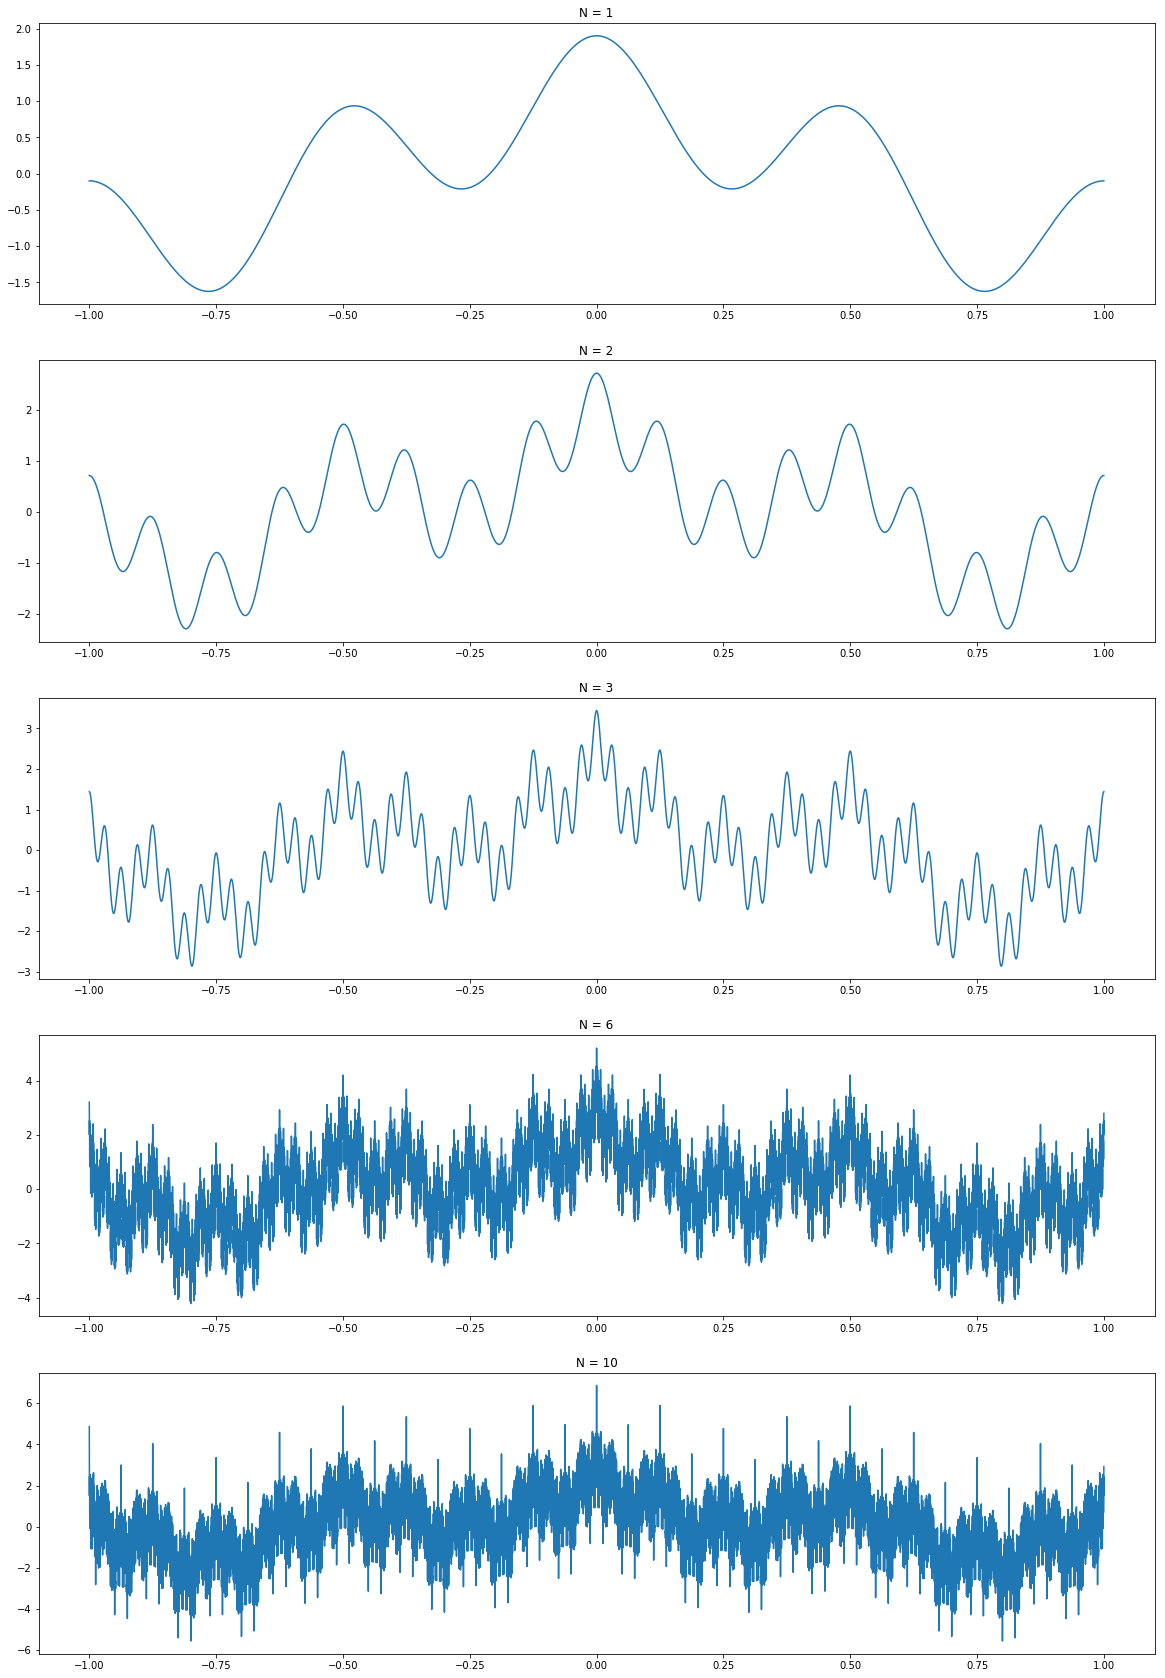

In [5]:
x = np.arange(-1, 1, 0.0001)
plt.figure(figsize=(20, 30))
plt.subplot(5, 1, 1)
plt.plot(x, W(1)(x))
plt.title("N = 1")
plt.subplot(5, 1, 2)
plt.plot(x, W(2)(x))
plt.title("N = 2")
plt.subplot(5, 1, 3)
plt.plot(x, W(3)(x))
plt.title("N = 3")
plt.subplot(5, 1, 4)
plt.plot(x, W(6)(x))
plt.title("N = 6")
plt.subplot(5, 1, 5)
plt.plot(x, W(10)(x))
plt.title("N = 10")

### Clearly, larger N means that the function will be more difficult to approximate. Let's start out with something easy, N=1:

Text(0.5,1,'N = 1')

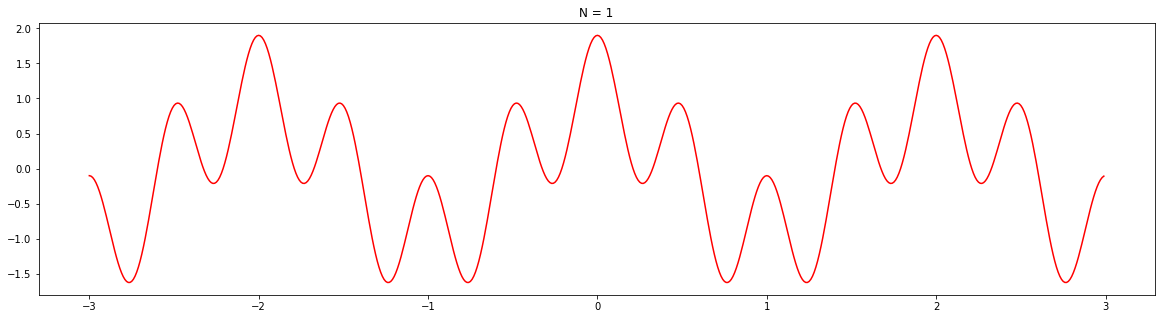

In [22]:
xs = np.arange(-3, 3, 0.01)
ys = W(1)(xs)
plt.figure(figsize=(20,5))
plt.subplot(111)
plt.plot(xs, ys, color='red')
plt.title("N = 1")

## How does fitness improve with model size?
Let's now create several single-hidden-layer neural networks and train them on the above dataset. The networks will be identical except that they will have different numbers of neurons in their hidden layer.

In [33]:
# Now let's import TensorFlow...
import tensorflow as tf 
# ... and define a useful function:
def get_model_predictions(size, xs, ys, steps=30000):
    """ Trains a single-hidden-layer ANN with 'size' neurons 
    in its hidden layer and returns Returns a set of outputs 
    'ys_pred' for the given xs that represent a regression over 'ys'.
    """
    x = tf.placeholder(tf.float32)
    W1 = tf.Variable(tf.random_normal([1, size]))
    b1 = tf.Variable(tf.random_normal([size]))
    y1 = tf.nn.tanh(tf.matmul(x, W1) + b1)
    y2 = tf.reduce_sum(y1, axis=1)
    sess = tf.Session()
    answer = tf.placeholder(tf.float32)
    loss = tf.reduce_sum(tf.pow(answer - y2, 2))
    step = tf.train.AdamOptimizer(1e-3).minimize(loss)
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        sess.run(step, feed_dict={x: np.expand_dims(xs, axis=1), answer: ys})
    print ("Network of size {} finished with loss: {}".format(size, \
                                    sess.run(loss, feed_dict={x: np.expand_dims(xs, axis=1), answer: ys})))
    return sess.run(y2, feed_dict={x: np.expand_dims(xs, axis=1)})

In [25]:
# Now let's get the various model predictions:
predictions = [get_model_predictions(n, xs, ys) for n in [5, 20, 50, 100, 500, 1000]]
# plt.figure(figsize=(20,5))
# plt.subplot(111)
# plt.plot(xs, ys, color='blue')
# plt.plot(xs, ys_model, color='red')

Network of size 5 finished with loss: 365.3968505859375
Network of size 20 finished with loss: 83.85420227050781
Network of size 50 finished with loss: 20.635284423828125
Network of size 100 finished with loss: 25.83301544189453
Network of size 500 finished with loss: 141.11009216308594
Network of size 1000 finished with loss: 149.15943908691406


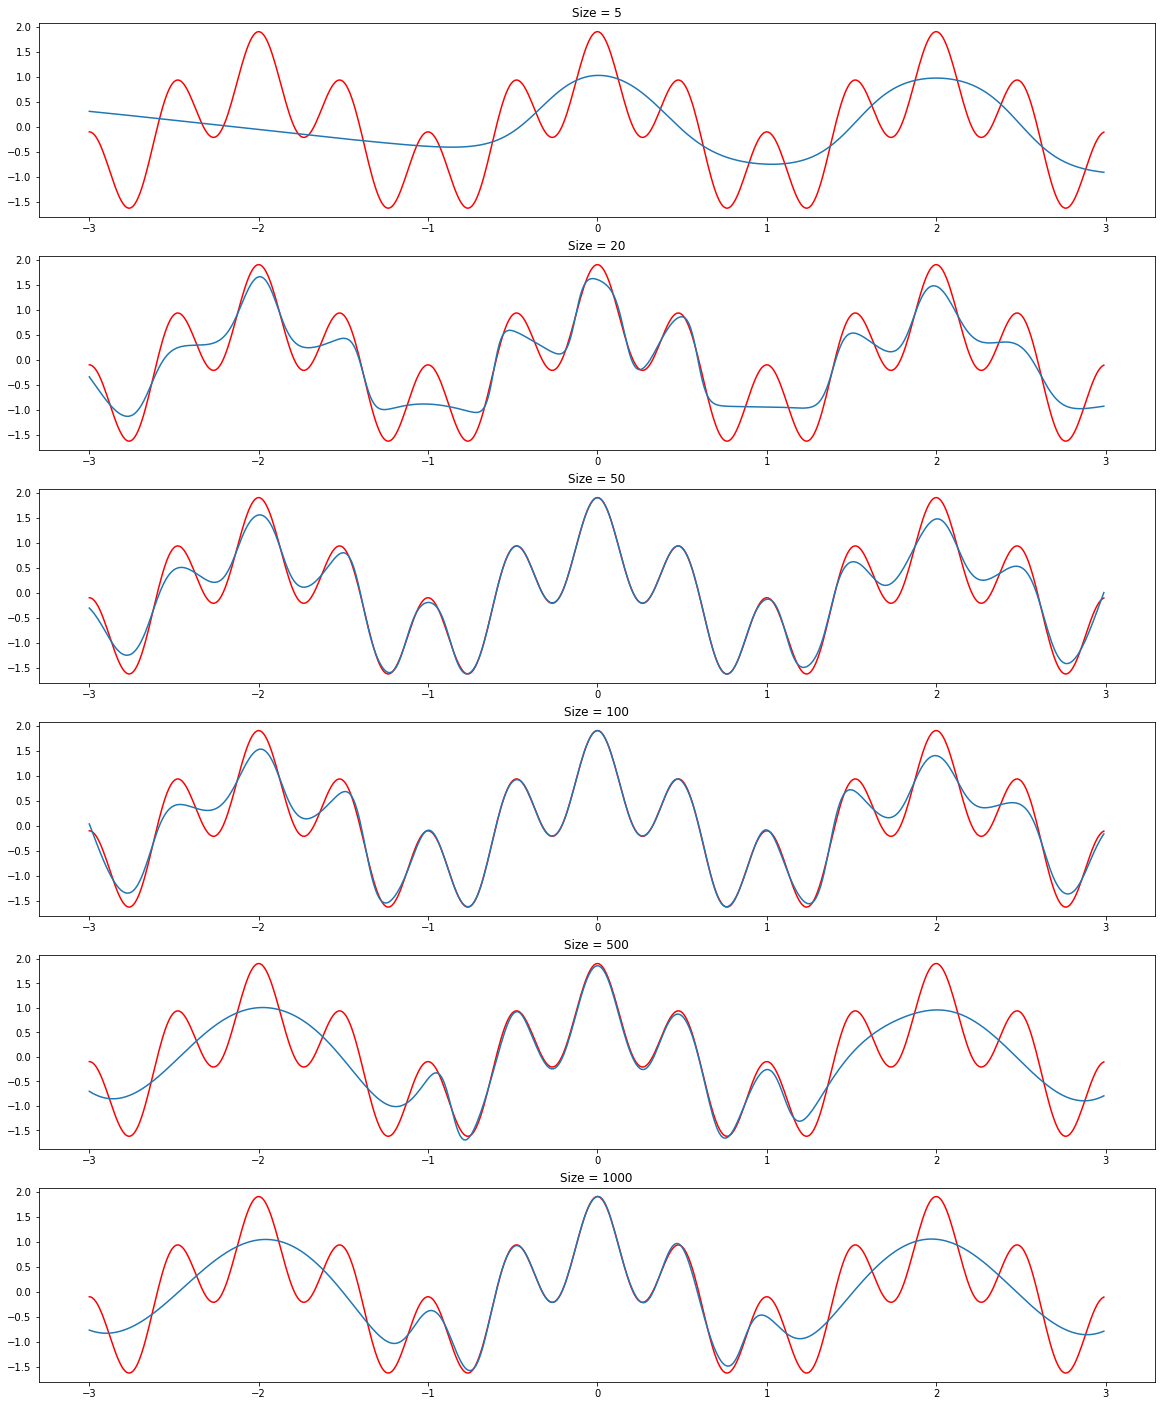

In [32]:
plt.figure(figsize=(20, 25))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(xs, ys, color='red')
    plt.plot(xs, predictions[i])
    plt.title("Size = {}".format([5, 20, 50, 100, 500, 1000][i]))
plt.show()

## Why does fitness get worse when 'size' > 100?
As we can see, the best-performing network had a 'size' of 50. This is due to the fact that each network had the same number of training steps (30000), and models with more parameters take longer to train. If we use more training steps, we get better results:

In [34]:
ys_pred = get_model_predictions(1000, xs, ys, 200000)

Network of size 1000 finished with loss: 33.6395149230957


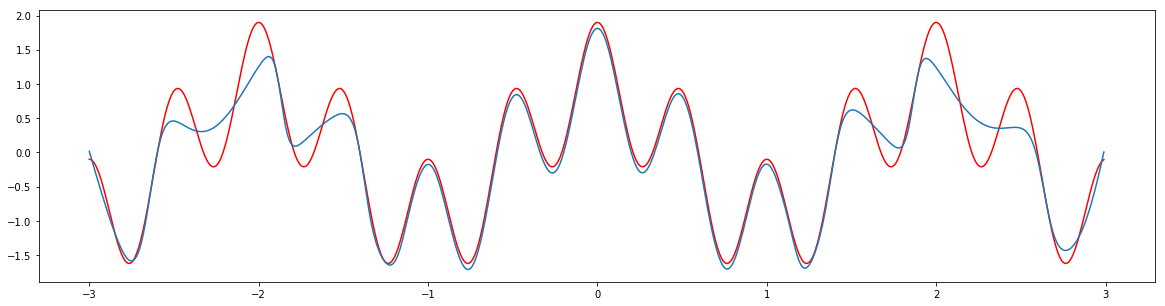

In [35]:
plt.figure(figsize=(20, 5))
plt.subplot(111)
plt.plot(xs, ys, color='red')
plt.plot(xs, ys_pred)